In [1]:
from functions_trained_reservoir import *

from IPython.display import clear_output

from reservoirpy.nodes import Reservoir,FORCE,Ridge
from reservoirpy.mat_gen import Initializer,_scale_spectral_radius
from reservoirpy.observables import spectral_radius
from tqdm import tqdm

from ReccurentNetwork import *

import numpy as np
import copy
from numpy.linalg import eig

import spicy as sp
import matplotlib.pyplot as plt

# Réseaux de neurones

On cherche ici dans un premier temps à reprdoduire les figures les plus simples de l'article. 

Les mesures de l'article sont effectuées sur 2 réservoirs : 

  - le premier est dit entrainé : on va alors entrainer le réservoir et la sortie
  - le second lui est dit non entrainé : on entraine seulement la sortie
    

Ce premier script s'intéresse donc à la reproduction de l'entrainement des figures 3, 4 et 5 ainsi qu'aux résultas obtenus sur un réservoir entrainé.


## Expériences

Deux expériences quasiment similaires sont proposés pour un réservoir totalement entrainé. La seule différence entre ces dernières sont le nombre de neurones utilisés dans le réservoir : 

   - Soit N = 2100 pour des résultats robustes entre toutes les données pour un sujet
   - Soit N = 4000 pour des résultats robustes entre tous les sujets (5 au maximum)
    
Nous traiterons le premier  cas dans ce papier.

##### Méthode d'entrainement

Pour ce qui est de l'entrainement du réservoir nous allons procéder en 2 étapes. En effet, nous séparons notre entrée en deux parties : l'époque sensorielle et l'époque motricielle. Nous séparons l'entrainement de ces 2 époques que je vais détailler ci dessous.

###### Epoque sensorielle : 

Pour un sujet donné et parmit toutes les entrées différentes, pour chaque chiffre on selectionne une entrée moyenne. Cette entrée est injectée dans le réservoir sans bruit et sans target, on obtient alors une trajectoire resultante de dimension (??) pour chaque chiffre. Ces 10 trajectoires sont appelées les "innate trajectories" et seront les targets pour toutes les autres entrées durant l'entrainement du l'époque sensorielle en faisant bien attention à  ce que la dimension d'entrée des nouvelles entrées soit cohérente avec celle de l'innate trajectorie, on procédera alors pas une déformation linéaire de l'innate trajectory. De plus, du bruit sera présent durant l'entrainement.

###### Epoque motrice

target = une target par chiffre peu importe l'entrée ou le sujet
c'est quoi la target ?? 
comprends la transition de 300 ms aussi


###### Test
Les test effectués dans ce script seront fait sur le sujet 1

Données générales 

In [2]:
data = extract_data() #Données d'entrée
transcription = extract_target() #Données d'arrivée 

#Les données suivantes sont utilisés dans les fonctions mais pas dans le script ! 

freq_ent = 6*10**3  #fréquence d'entrée
T_ent = 1/freq_ent  #période d'entrée

freq_out = 10**3 #fréquence de sortie 
T_out = 1/freq_out #période de sortie

ampl_int = 5 #Amplitude d'entrée

Données du réservoir

In [3]:
N = 2100//5 #Nombre de neurones dans le réservoir
M = 12 #Nombres d'entrées
No = 3 #Nombres de sorties
tau = 25*10e-3
dt = 1e-3
lr = dt/tau
sr = 1.6 #spectral radius --> gain ?
g = 1.6 #le gain du réseau ?                             #je comprends pas trop cette donnée. 
pc = 0.2 # connectivité entre les neurones (pc dans l'article)
SD = g/np.sqrt(pc*N)
mu = 0
I0 = 0.5 

Wo = normal(No,N,loc=mu,scale = 1/np.sqrt(N))    #Matrice de sortie : Non utilisée


Création de la matrice du réservoir : avec pas d'autapse
Puis bricolage pour réxupérer le rayon spectral voulu

In [4]:
W_r.init = Initializer(W_r)

W = _scale_spectral_radius(W_r.init, [N,N], sr)
W = W.toarray()

#Vérification du rayon spectral

a,b=eig(W)
print(np.max(np.abs(a)))


1.600000000000003


Création de la matrice d'entrée : chaque entrée k est projetée sur le neurone $(k-1)\frac{N}{M} + 1$ jusqu'au neurone $k\frac{N}{M}$ selon une loi normale 

In [5]:
Win = W_in(N,M)

# Epoque sensorielle 

Récupération des cocleograms avec une taille moyenne pour chaque chiffre 

In [6]:
median_entrance_cocleogram = median_cocleogram(data,sujet=[1])

Création d'un réservoir :

In [7]:
reservoir_train = Reservoir(W=W,Win=Win)

Détermination des trajectoires inées  

In [8]:
innate_trajectories_sensor = []
innate_trajectories_motor = []
for i in range(len(median_entrance_cocleogram)):
    
    #Récupération du cocleogram moyen
    X =  median_entrance_cocleogram[i]
    
    #Récupération des trajectoires innées de l'époque sensorielle 
    initial_trajectory = reservoir_train.run(X)
    
    #Ensuite on les trie
    innate_trajectories_sensor.append(initial_trajectory)

clear_output()

## Entrainement de l'epoque sensorielle.

Récupération des données d'entrées et des targets, ici on entraîne sur un sujet, 3 entrées et les 10 chiffres

Attention : penser à rajouter du bruit !!!!

In [9]:
X_input = []
X_target = []
for indS in [1] : 
    for indU in range(1,4):
        for indD in range(10):
            X_input.append(np.transpose(cocleogram(indS, indU, indD,data)))
            X_target.append(linear_warping(indS,indU,indD,data,innate_trajectories_sensor[indD]))

Algorithme d'entrainement

In [10]:
#Code importé de ReservoirPy
def _rls(P, x, e):
    """Recursive Least Squares learning rule."""
    k = np.dot(P, x)
    xPx = np.dot(x.T, k)
    c = float(1.0 / (1.0 + xPx))
    P = P - c * np.outer(k, k)
    dw = -c * np.outer(e, k)

    return dw, P



## Test de RLS sans utiliser le noeud de reservoirpy

In [11]:
I_noise = np.random.normal(0,1,size = 3) + SD*I0   #bruit dans le réservoir
print(I_noise)
print(SD)

[-0.56146014 -0.99128548  0.43582162]
0.17457431218879393


Aprentissage

In [12]:
P = np.identity(N)                                                  # matrice de gain ?
x = np.random.normal(0,1,(N,1))                              #etats initiaux du réservoir
W_rls = copy.deepcopy(W)
c = 0



for xi,xt in tqdm(zip(X_input,X_target)):                              #entrainement
    error = []
    for t in range(len(xi)):                                           # pour 1 pas de temps 
        
        I_noise = np.random.normal(0,1,size =np.shape(x)) + SD*I0                     #bruit dans le réservoir
        
        x1 = (1-lr)*x + lr*np.tanh(np.dot(Win,np.expand_dims(xi[t], axis=1))+np.dot(W_rls,x)) + I_noise  #calcul de x(t+1)
        
        e = np.expand_dims(xt[t],axis=1) - x1                       #calcul de l'erreur pour un seul pas de temps
        
        
        dW_rls,P = _rls(P, x1, e)                                       #calcul du rls pour un pas de temps 
        
        W_rls -= dW_rls
        
        x = x1
        
        error.append(e)
    
    c += 1
        
    print("moyenne des erreurs sur l'entrainement {} : {} ".format(c,moyenne(e)))
        


1it [00:01,  1.76s/it]

moyenne des erreurs sur l'entrainement 1 : [-17.7269904] 


2it [00:03,  1.69s/it]

moyenne des erreurs sur l'entrainement 2 : [-20.90425394] 


3it [00:05,  1.88s/it]

moyenne des erreurs sur l'entrainement 3 : [-21.29944195] 


4it [00:07,  2.11s/it]

moyenne des erreurs sur l'entrainement 4 : [-22.02532156] 


5it [00:10,  2.22s/it]

moyenne des erreurs sur l'entrainement 5 : [-21.43700245] 


6it [00:13,  2.38s/it]

moyenne des erreurs sur l'entrainement 6 : [-21.65850369] 


7it [00:16,  2.58s/it]

moyenne des erreurs sur l'entrainement 7 : [-19.75466633] 


8it [00:18,  2.52s/it]

moyenne des erreurs sur l'entrainement 8 : [-20.47587069] 


9it [00:20,  2.36s/it]

moyenne des erreurs sur l'entrainement 9 : [-21.07511892] 


10it [00:22,  2.40s/it]

moyenne des erreurs sur l'entrainement 10 : [-20.36721676] 


11it [00:24,  2.26s/it]

moyenne des erreurs sur l'entrainement 11 : [-20.47513176] 


12it [00:26,  2.02s/it]

moyenne des erreurs sur l'entrainement 12 : [-20.16617747] 


13it [00:28,  1.94s/it]

moyenne des erreurs sur l'entrainement 13 : [-21.08850213] 


14it [00:30,  1.97s/it]

moyenne des erreurs sur l'entrainement 14 : [-20.36904989] 


15it [00:32,  2.05s/it]

moyenne des erreurs sur l'entrainement 15 : [-22.36610614] 


16it [00:35,  2.22s/it]

moyenne des erreurs sur l'entrainement 16 : [-20.53224237] 


17it [00:37,  2.44s/it]

moyenne des erreurs sur l'entrainement 17 : [-21.28227797] 


18it [00:40,  2.60s/it]

moyenne des erreurs sur l'entrainement 18 : [-19.8431265] 


19it [00:43,  2.48s/it]

moyenne des erreurs sur l'entrainement 19 : [-19.61101374] 


20it [00:45,  2.56s/it]

moyenne des erreurs sur l'entrainement 20 : [-21.51368397] 


21it [00:48,  2.44s/it]

moyenne des erreurs sur l'entrainement 21 : [-21.61232512] 


22it [00:49,  2.21s/it]

moyenne des erreurs sur l'entrainement 22 : [-21.80463875] 


23it [00:51,  2.14s/it]

moyenne des erreurs sur l'entrainement 23 : [-22.38544321] 


24it [00:54,  2.26s/it]

moyenne des erreurs sur l'entrainement 24 : [-21.19526732] 


25it [00:56,  2.19s/it]

moyenne des erreurs sur l'entrainement 25 : [-20.62290958] 


26it [00:58,  2.28s/it]

moyenne des erreurs sur l'entrainement 26 : [-20.52040635] 


27it [01:01,  2.44s/it]

moyenne des erreurs sur l'entrainement 27 : [-20.21376892] 


28it [01:04,  2.60s/it]

moyenne des erreurs sur l'entrainement 28 : [-21.37718084] 


29it [01:07,  2.60s/it]

moyenne des erreurs sur l'entrainement 29 : [-20.54468012] 


30it [01:09,  2.33s/it]

moyenne des erreurs sur l'entrainement 30 : [-21.3377973] 


Affichage des valeurs propres

C:\Users\smoot\Desktop\Stage Mnemosyne\functions_trained_reservoir.py:465: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


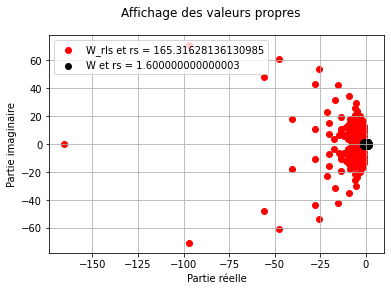

In [13]:
eigein_value(W_rls,W,"W_rls","W")

Test :

In [14]:
X_test = X_input[1]
X_target_test = X_target[1]
x = np.random.normal(0,1,(N,1))

X_pred = []

for t in tqdm(range(len(X_test))):
    x1 = (1-lr)*x + lr*np.tanh(np.dot(Win,np.expand_dims(X_test[t], axis=1))+np.dot(W,x))
    
    if len(X_pred) == 0:
        X_pred = np.transpose(x1)
    else : 
        X_pred = np.append(X_pred,np.transpose(x1),axis = 0)
    
    x = x1

100%|██████████████████████████████████████████████████████████████████████████████| 448/448 [00:00<00:00, 2194.70it/s]


Affichage des résultats (pas représentatif)

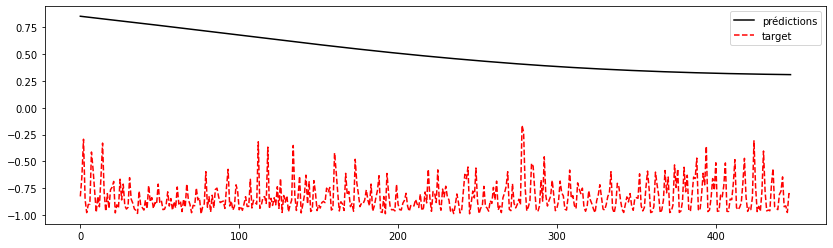

In [15]:
fig,ax = plt.subplots(figsize = (14,4))
ax.plot(X_pred[:,:1],"k",label="prédictions")
ax.plot(X_target_test[:,:1],"--r",label = 'target')
ax.legend()

## Test de RLS en utilisant le noeud de reservoirpy

Entrainement

In [16]:
W_reservoir = copy.deepcopy(W)
reservoir = Reservoir(W=W_reservoir,Win=Win,rc_noise = SD*I0)
P = np.identity(N)

np.shape(xt)

for xi,xt in tqdm(zip(X_input,X_target)):
    x1 = reservoir.run(xi)
    e = x1-xt
    for t in range(len(x1)):
        dW, P = _rls(P,x1[t],e[t])
        W_reservoir -= dW
    reservoir.set_param("W",W_reservoir)

    clear_output()
    #print(moyenne(e))
    

30it [01:07,  2.27s/it]


Affichage des valeurs propores :

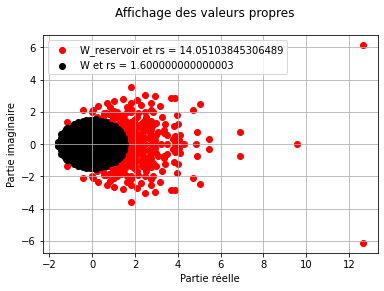

In [17]:
eigein_value(W_reservoir,W,"W_reservoir","W")

Test du réservoir 

In [18]:
X_test = X_input[1]
X_target_test = X_target[1]

X_pred = reservoir.run(X_test)

Running Reservoir-1: 100%|█████████████████████████████████████████████████████████| 448/448 [00:00<00:00, 4545.40it/s]


Affichage des résultats (pas représentatif)

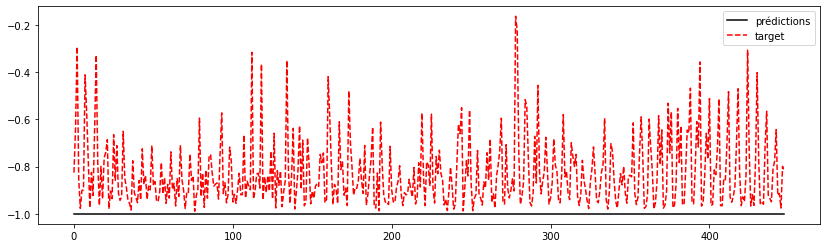

In [19]:
fig,ax = plt.subplots(figsize = (14,4))
ax.plot(X_pred[:,:1],"k",label="prédictions")
ax.plot(X_target_test[:,:1],"--r",label = 'target')
ax.legend()

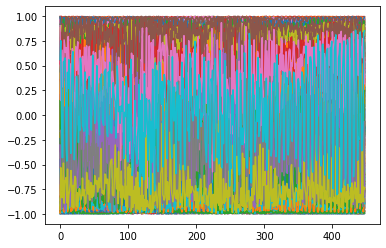

In [20]:
plt.plot(X_target[1])

# Epoque motrice